In [1]:
import torch
import numpy as np
import os
import math
import warnings
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from torch.nn import functional as F

from transformers import logging
from transformers import set_seed
from transformers import GPT2Model, GPT2Config, GPT2LMHeadModel
from transformers import GPT2Tokenizer

set_seed(2024)

logging.set_verbosity_error()
def create_folder(dir):
    if not os.path.isdir(dir):
        os.mkdir(dir)

## A study of induction head

In [32]:
configuration = GPT2Config()
model = GPT2LMHeadModel.from_pretrained("gpt2", output_attentions=True, output_hidden_states=True)
configuration = model.config
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

sample_int = np.random.randint(low=0,high=50257,size=5).repeat(3).reshape(5,-1).T.ravel()
input_ids = torch.Tensor(sample_int).long().unsqueeze(0)

with torch.no_grad():
    output = model(input_ids) # (num_layer, num_head, seq_length, seq_length) = (12, 12, 128, 128)
len(output.attentions), output.attentions[0].size()

attentions = np.array([a.detach().numpy()[0] for a in output.attentions])
attentions.shape

(12, 12, 15, 15)

In [3]:
input_ids

tensor([[ 7816, 35456, 47643, 30244,  2494,  7816, 35456, 47643, 30244,  2494,
          7816, 35456, 47643, 30244,  2494]])

In [4]:
model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

tensor(7816)


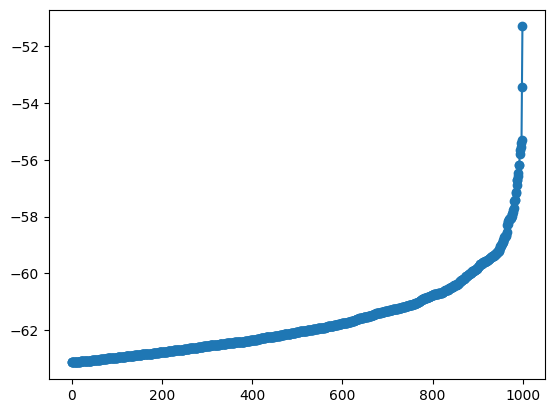

In [30]:
L, T = 12, input_ids.size(1)
pos = torch.arange(0, T, dtype=torch.long).unsqueeze(0)
p = model.transformer.wpe(pos)
t = model.transformer.wte(input_ids)
h = model.transformer.drop(t + 5*p)
for layer in range(L):
    block = model.transformer.h[layer]
    h1 = block.ln_1(h)
    h = model.transformer.h[layer](h)[0]
h = model.transformer.ln_f(h)
logits = model.lm_head(h)
print(logits[0, -1].argmax())
plt.plot(sorted(logits[0, -1].numpy(force=True))[-1000:], marker="o")
pass

In [35]:
len(output.hidden_states), output.hidden_states[0].shape

(13, torch.Size([1, 15, 768]))

In [37]:
num_heads = 12
n_layer = 12
seq_len = input_ids.size(0)
d_model = 768
layer, head = 5, 1

hiddens = output.hidden_states
h = hiddens[layer]
block = model.transformer.h[layer]

h2 = block.ln_1(h)

q, k, _  = block.attn.c_attn(h2).split(d_model, dim=2)
k = k.view(1, seq_len, num_heads, d_model // num_heads).transpose(1, 2) # (B, nh, T, hs)
q = q.view(1, seq_len, num_heads, d_model // num_heads).transpose(1, 2) # (B, nh, T, hs)

# causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
mask = torch.tril(torch.ones(50,50).view(1,1,50,50))
QK = ((q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1))))
att = QK.masked_fill(mask[:,:,:seq_len,:seq_len] == 0, float('-inf'))
att = F.softmax(att, dim=-1)
att = att.squeeze().numpy(force=True)
QK = QK.squeeze().numpy(force=True)

plt.imshow(QK[head][1:,1:])

RuntimeError: shape '[1, 1, 12, 64]' is invalid for input of size 11520

<Axes: >

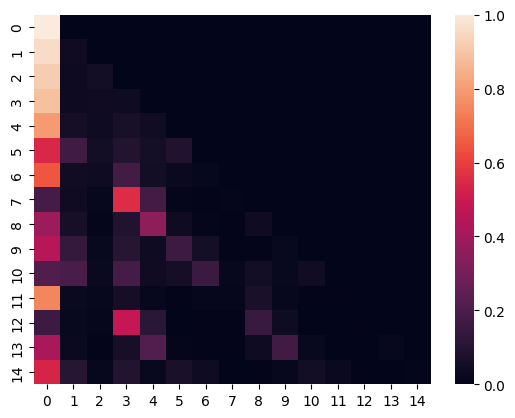

In [81]:
import seaborn as sns
layer, head = 10, 4

with torch.no_grad():
    output = model(input_ids)
len(output.attentions), output.attentions[0].size()

attentions = np.array([a.detach().numpy()[0] for a in output.attentions])
sns.heatmap(attentions[layer][head])

<AxesSubplot:>

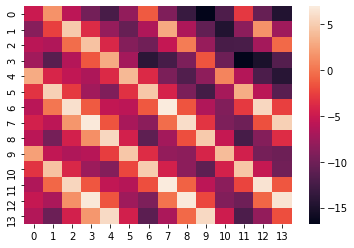

## Now Check weights 

<AxesSubplot:>

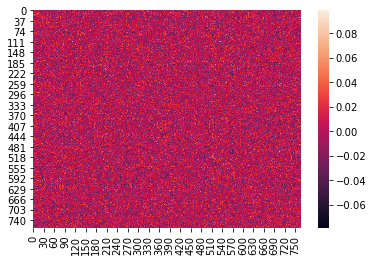

In [8]:
layer, head = 5, 1
W_q, W_k, W_v = model.h[layer].attn.c_attn.weight.split(d_model, dim=1)
W_q = W_q.view(d_model, num_heads, d_model//num_heads)
W_k = W_k.view(d_model, num_heads, d_model//num_heads)
W_qk = np.zeros((num_heads,  d_model,  d_model))

for head in range(num_heads): 
    W_qk[head] = (W_q[:,head,:] @ W_k[:,head,:].T / np.sqrt(d_model//num_heads)).squeeze().numpy(force=True)

sns.heatmap(W_qk[head][1:,1:])

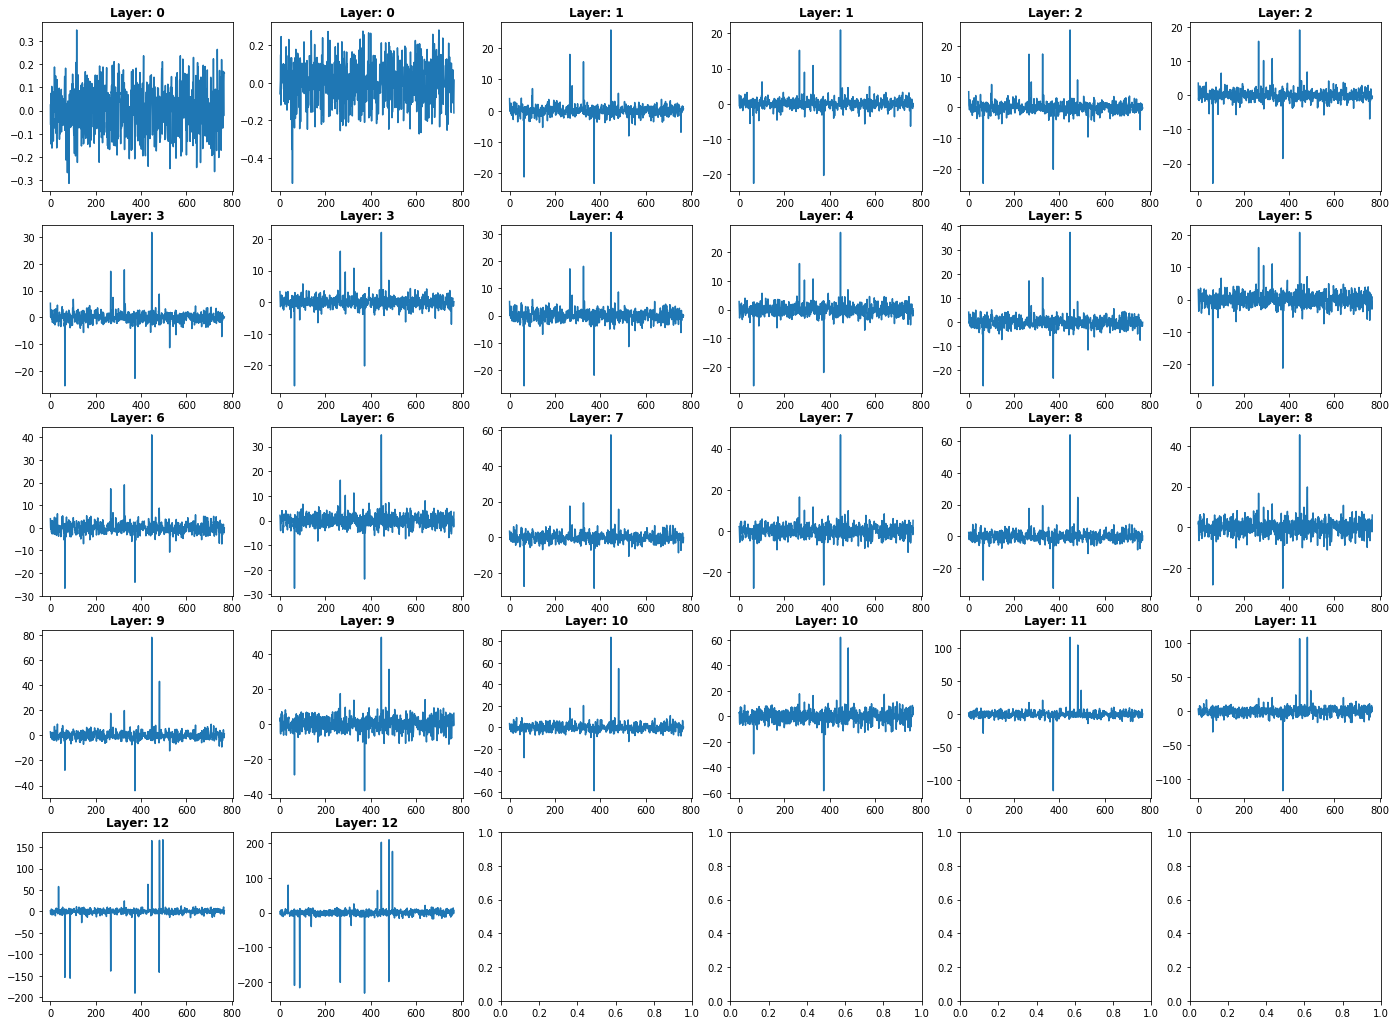

In [9]:
pos1, pos2 = 5, 9

fig, axs = plt.subplots(5, 6, figsize=(24,18))
for layer in range(num_layer+1):
    axs[layer//3, 2*(layer%3) + 0].plot(hiddens_all[layer][pos1].numpy(force=True))
    axs[layer//3, 2*(layer%3) + 1].plot(hiddens_all[layer][pos2].numpy(force=True))
    axs[layer//3, 2*(layer%3) + 0].set_title(f'Layer: {layer}', weight='bold')
    axs[layer//3, 2*(layer%3) + 1].set_title(f'Layer: {layer}', weight='bold')
plt.show()

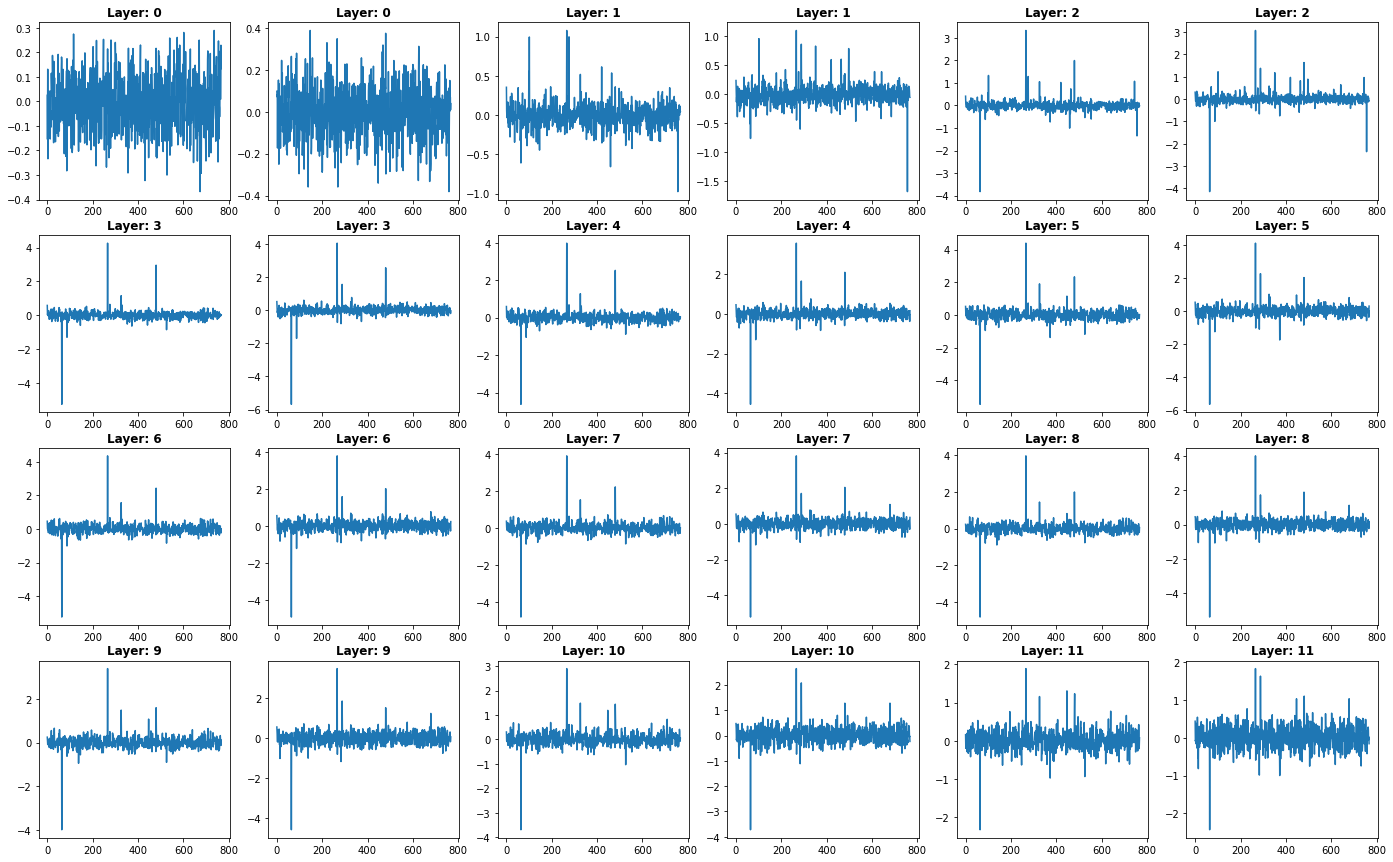

In [10]:
pos1, pos2 = 5, 8

fig, axs = plt.subplots(4, 6, figsize=(24,15))
for layer in range(num_layer):
    axs[layer//3, 2*(layer%3) + 0].plot(hiddens2_all[layer+1][pos1].numpy(force=True))
    axs[layer//3, 2*(layer%3) + 1].plot(hiddens2_all[layer+1][pos2].numpy(force=True))
    axs[layer//3, 2*(layer%3) + 0].set_title(f'Layer: {layer}', weight='bold')
    axs[layer//3, 2*(layer%3) + 1].set_title(f'Layer: {layer}', weight='bold')
plt.show()

In [11]:
layer = 5
pos1, pos2 = 5, 10

arr = hiddens2_all[layer+1].numpy(force=True)
indices = np.argsort(np.abs(arr[pos1]))[::-1]
indices_max = indices[:10]
indices_not_max = indices[10:]

for j in range(5, 11):
    val1 = cosine_sim(arr[pos1][indices_not_max], arr[j][indices_not_max])
    val2 = cosine_sim(arr[pos1][indices_max], arr[j][indices_max])
    print(f'Layer: {layer}, Pos: {pos1} {j}, Similarity', val1, val2)

Layer: 5, Pos: 5 5, Similarity 1.0 1.0
Layer: 5, Pos: 5 6, Similarity 0.2333 0.977
Layer: 5, Pos: 5 7, Similarity 0.1375 0.9857
Layer: 5, Pos: 5 8, Similarity 0.2231 0.974
Layer: 5, Pos: 5 9, Similarity 0.2323 0.9765
Layer: 5, Pos: 5 10, Similarity 0.9212 0.9936


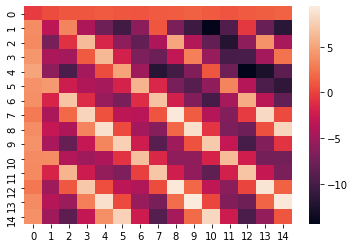

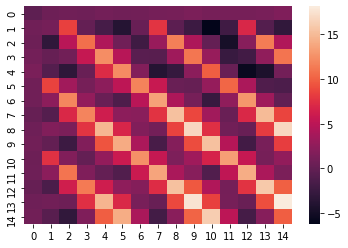

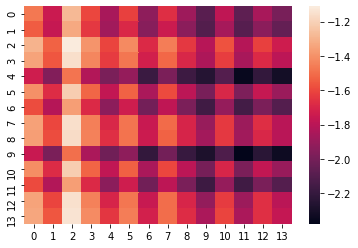

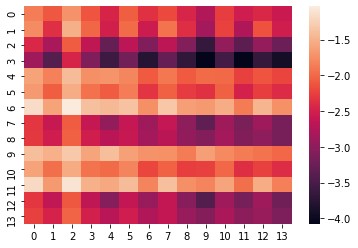

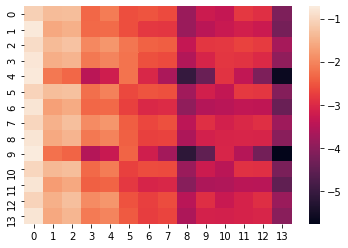

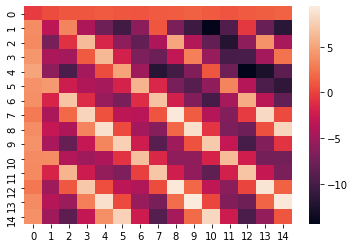

In [12]:
head = 1

W_sub = W_qk[head]
val0 = np.zeros((seq_len, seq_len))
for j1 in range(seq_len):
    for j2 in range(seq_len):
        val0[j1,j2] = arr[j1].reshape(1,d_model) @ W_sub @ arr[j2].reshape(d_model,1)
sns.heatmap(val0)
plt.show()

W_sub = W_qk[head][indices_not_max].T[indices_not_max]
val1 = np.zeros((seq_len, seq_len))
for j1 in range(seq_len):
    for j2 in range(seq_len):
        val1[j2,j1] = arr[j1][indices_not_max].reshape(1,len(indices_not_max)) @ W_sub @ arr[j2][indices_not_max].reshape(len(indices_not_max),1)
sns.heatmap(val1)
plt.show()

W_sub = W_qk[head][indices_max].T[indices_max]
val2 = np.zeros((seq_len, seq_len))
for j1 in range(seq_len):
    for j2 in range(seq_len):
        val2[j2,j1] = arr[j1][indices_max].reshape(1,len(indices_max)) @ W_sub @ arr[j2][indices_max].reshape(len(indices_max),1)
sns.heatmap(val2[1:,1:])
plt.show()

W_sub = W_qk[head][indices_not_max].T[indices_max]
val3 = np.zeros((seq_len, seq_len))
for j1 in range(seq_len):
    for j2 in range(seq_len):
        val3[j2,j1] = arr[j1][indices_max].reshape(1,len(indices_max)) @ W_sub @ arr[j2][indices_not_max].reshape(len(indices_not_max),1)
sns.heatmap(val3[1:,1:])
plt.show()

W_sub = W_qk[head][indices_max].T[indices_not_max]
val4 = np.zeros((seq_len, seq_len))
for j1 in range(seq_len):
    for j2 in range(seq_len):
        val4[j2,j1] = arr[j1][indices_not_max].reshape(1,len(indices_not_max)) @ W_sub @ arr[j2][indices_max].reshape(len(indices_max),1)
sns.heatmap(val4[1:,1:])
plt.show()

val = val1 + val2 + val3 + val4
sns.heatmap(val)
plt.show()

In [13]:
pos1, pos2 = 5, 9
sigma = np.sqrt(np.mean(W_qk ** 2))
a = arr[pos1].reshape(1, d_model) @ (sigma * np.random.randn(d_model, d_model)) @ arr[pos2].reshape(d_model, 1)
print(a)

[[4.08878185]]


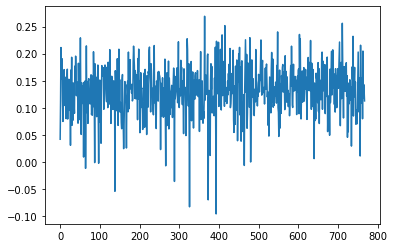

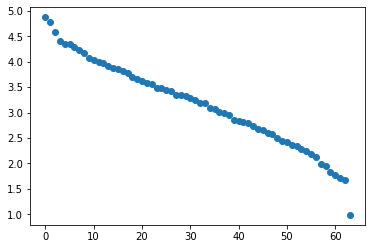

In [14]:
plt.plot(np.diag(W_qk[head]))
plt.show()
u, s, vt = np.linalg.svd(W_qk[head])
plt.scatter(np.arange(d_model//num_heads), s[:d_model//num_heads])
plt.show()